# Energy Requirements for Separating CO2/O2 Mixtures

In this notebook, we develop models and figures associated with "Electrolyzer Energy Dominates Separation Costs in State-of-the-Art CO2 Electrolyzers: Implications for Single-Pass CO2 Utilization" by Moore et al. In particular, in this notebook, we estimate the energy required to separate CO2/O2 mixtures via various different technologies. We compare these with the theoretical minimum for a reversible separation process. 

## Chemical Absorption, MEA

We begin by estimating the energy required if we were to capture the CO2 using monoethanolamine (MEA). The vast majority of the energy required for this process consists of thermal energy supplied in the stripper. A reliable approach to estimating stripper heat duties is to use the shortcut approach of Kim et al. (10.1021/es504684x). This is basically just an energy balance over the stipper, where they assume (as one case, which we will consider here) that the concentration of water in the gas exiting the top of the stripper is at equilibrium with the aqueous amine, and the temperature at the top of the stripper equals the temperature of the rich solvent entering the column (sec. 3.1 of their paper). Their approach only requires vapor-liquid equlibria data for the solvent and estimates of a few other physical parameters, such as heat capacities. For the vapor-liquid equilibria, we use the expression of Gabrielson et al (10.1021/ie048857i) for MEA. 

### VLE for MEA

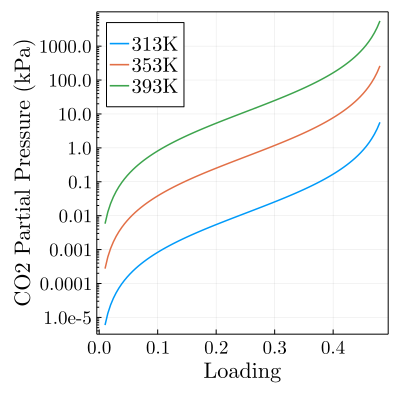

In [1]:
using Plots
using Roots
using NLsolve
using LaTeXStrings
using Optim
MColor = ["#0072BD", "#D95319", "#EDB120", "#7E2F8E", "#77AC30", "#4DBEEE"]

########
#MEA VLE
########
#Predict equilibrium CO2 partial pressure, pCO2, as a function of 
#temperature, CO2 loading, and initial (zero loading) mole fraction of amine.
#pCO2: CO2 pressure, Pa
#T: Temperature, K
#α: mol CO2/unloaded mol amine
#x_am: unloaded amine mol fraction
function pCO2_MEA_Gabrielson(T, α, x_am; A = 30.96, B = -10584, C = -7.187)
    if 0.0 <= α <= 0.5
        return 1e3*exp(A + B/T + C*x_am*α) * α^2 / (1-2α)^2
    elseif α < 0.0
        return 0.0
    elseif α > 0.5
        return 1e6*α
    end
end

plot(LinRange(0.01, 0.48, 100), α -> pCO2_MEA_Gabrielson(313, α, 0.11)/1000,
    label = "313K", lw = 1.5)
plot!(LinRange(0.01, 0.48, 100), α -> pCO2_MEA_Gabrielson(353, α, 0.11)/1000,
    label = "353K", lw = 1.5)
plot!(LinRange(0.01, 0.48, 100), α -> pCO2_MEA_Gabrielson(393, α, 0.11)/1000,
    label = "393K", lw = 1.5,
    legend = :topleft,
    xlabel = "Loading", 
    yminorticks=9,
    ylabel = "CO2 Partial Pressure (kPa)", 
    yaxis = :log10, 
    yticks=([0.00001,0.0001,0.001,0.01, 0.1, 1, 10, 100, 1000], [0.00001,0.0001,0.001,0.01, 0.1, 1, 10, 100, 1000]), 
    size = (400,400), 
    framestyle=:box, 
    legendfontsize = 13,
    tickfont = font(12, "serif-roman"), 
    fontfamily = "serif-roman", 
    guidefontsize = 14)

## Antoine Equation for Water
We also require an antione equation for water; we use the function of Stull, Daniel R., Vapor Pressure of Pure Substances. Organic and Inorganic Compounds, Ind. Eng. Chem., 1947, 39, 4, 517-540.

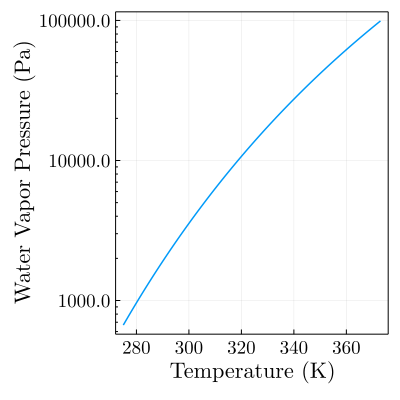

In [2]:
###########################
#Antione Equation for Water
###########################

#Input T in Kelvin. 
#Output pvap of pure water in Pa.
#Taken from Stull (1947) in NIST Webook, 
#https://webbook.nist.gov/cgi/cbook.cgi?ID=C7732185&Mask=4&Type=ANTOINE&Plot=on

function pvap_water_Stull(T; A = 4.6543, B = 1435.264, C = -64.848) 
    return 10^(A - (B / (T + C))) * 1e5
end

plot(LinRange(275, 373, 100), T -> pvap_water_Stull(T),
    lw = 1.5,
    legend = false,
    xlabel = "Temperature (K)", 
    ylabel = "Water Vapor Pressure (Pa)", 
    yaxis = :log10, 
    yticks=([0.00001,0.0001,0.001,0.01, 0.1, 1, 10, 100, 1000]*1e3, [0.00001,0.0001,0.001,0.01, 0.1, 1, 10, 100, 1000]*1e3), 
    size = (400,400), 
    framestyle=:box, 
    yminorticks=9,
    tickfont = font(12, "serif-roman"), 
    fontfamily = "serif-roman", 
    guidefontsize = 14)

# Stripper Energy Requirements, MEA

We follow the approach of Kim et al. 10.1021/es504684x, Environ. Sci. Technol. 2015, 49, 1478−1485. I am tempted to follow the even simpler approach of Kather and Oexmann (10.1016/j.ijggc.2009.09.010) but as we will be considering a broad range of conditions, the more rigorous methodology of Kim is worth adopting.



In [3]:
function Q_regen(;
    M = 2.2727e4, cam = 170, cw = 75, cCO2 = 37.0, Δh = -82000, λ = 40000, ΔT_MTA = 10.0,
    T1 = 318.15, T4 = 313.15, αrich = 0.45, αlean = 0.3, rw = 7.9, p = 2e5, 
    pCO2 = pCO2_MEA_Gabrielson, pwater = pvap_water_Stull, maxloading = 0.5)
    
    function Q_regen_internal(mw, Ttop; 
        M = 2.2727e4, cam = 170, cw = 75, cCO2 = 37.0, Δh = -82000, λ = 40000, ΔT_MTA = 10.0,
        T1 = 318.15, T4 = 313.15, αrich = 0.45, αlean = 0.3, rw = 7.9, p = 2e5,
        pCO2 = pCO2_MEA_Gabrielson, pwater = pvap_water_Stull, maxloading = 0.5)
  
        T2 = T1 + ΔT_MTA
        mam = M / (αrich - αlean)

        Qlatent = mw*λ
        Qrxn = -mam * (αrich - αlean)*Δh
        Qsen = mam*(cam + rw*cw + αlean*cCO2)*(T2 - T1) + M*cCO2*(Ttop - T1) + mw*cw*(Ttop - T4)
        Qregen = Qlatent + Qrxn + Qsen
        return (Qregen, Qlatent, Qrxn, Qsen)
    end
    
    function Estimate_Ttop(;
         M = 2.2727e4, cam = 170, cw = 75, cCO2 = 37.0, Δh = -82000, λ = 40000, ΔT_MTA = 10.0,
         T1 = 318.15, T4 = 313.15, αrich = 0.45, αlean = 0.3, rw = 7.9, p = 1.6e5,
         pCO2 = pCO2_MEA_Gabrielson, pwater = pvap_water_Stull, maxloading = 0.5)
    
        T2 = T1 + ΔT_MTA
        xwfresh = rw/(1+rw)

        Ptotal(T6) = pCO2(T6, αlean, 1-xwfresh) + xwfresh*pwater(T6)

        T6 = find_zero(x -> Ptotal(x) - p, (313.0, 423.0))

        function resid!(F, x)

            T5 = x[1]
            rw5l = x[2]
            α5l = x[3]

            F[1] = ((cam + rw*cw)*(-ΔT_MTA + T6 - T5) + cCO2*(αlean*(T6 - T2) - αrich*(T5 - T1)) - (rw - rw5l)*λ + (αrich - α5l)*Δh) / 1e4 
            F[2] = (pCO2(T5, α5l, 1-xwfresh) + xwfresh*pwater(T5) - p) / 1e5 
            F[3] = (αrich - α5l) * xwfresh*pwater(T5) - (rw - rw5l) * pCO2(T5, α5l, 1-xwfresh) 

        end
        sol = nlsolve(resid!, [ 373.0; 7.5; 0.3])
        (T5, rw5l, α5l) = sol.zero

        return (T5, rw5l, α5l, T6, sol)
    end

    function Estimate_mw(Ttop; 
        M = 2.2727e4, cam = 170, cw = 75, cCO2 = 37.0, Δh = -82000, λ = 40000, ΔT_MTA = 10.0,
        T1 = 318.15, T4 = 313.15, αrich = 0.45, αlean = 0.3, rw = 7.9, p = 1.6e5,
        pCO2 = pCO2_MEA_Gabrielson, pwater = pvap_water_Stull, maxloading = 0.5)

        xwfresh = rw/(1+rw)

        Ptotal(αtop) = pCO2(Ttop, αtop, 1-xwfresh) + xwfresh*pwater(Ttop)

        αtop = find_zero(x -> Ptotal(x) - p, (0.0, maxloading))

        mw = M*pwater(Ttop)/pCO2(Ttop, αtop, 1-xwfresh)
        return (mw, αtop, pCO2(Ttop, αtop, 1-xwfresh), xwfresh*pwater(Ttop))
    end
    
    Ttop = Estimate_Ttop(;
         M = M, cam = cam, cw = cw, cCO2 = cCO2, Δh = Δh, λ = λ, ΔT_MTA = ΔT_MTA,
         T1 = T1, T4 = T4, αrich = αrich, αlean = αlean, rw = rw, p = p, 
         pCO2 = pCO2, pwater = pwater, maxloading = maxloading)[1]
    mw = Estimate_mw(Ttop; 
         M = M, cam = cam, cw = cw, cCO2 = cCO2, Δh = Δh, λ = λ, ΔT_MTA = ΔT_MTA,
         T1 = T1, T4 = T4, αrich = αrich, αlean = αlean, rw = rw, p = p,
         pCO2 = pCO2, pwater = pwater, maxloading = maxloading)[1]
    
    (Qregen, Qlatent, Qrxn, Qsen) = Q_regen_internal(mw, Ttop; 
        M = M, cam = cam, cw = cw, cCO2 = cCO2, Δh = Δh, λ = λ, ΔT_MTA = ΔT_MTA,
         T1 = T1, T4 = T4, αrich = αrich, αlean = αlean, rw = rw, p = p,
         pCO2 = pCO2, pwater = pwater, maxloading = maxloading)
    
    return (Qregen, Qlatent, Qrxn, Qsen)
    
end

function Estimate_Ttop(;
         M = 2.2727e4, cam = 170, cw = 75, cCO2 = 37.0, Δh = -82000, λ = 40000, ΔT_MTA = 10.0,
         T1 = 318.15, T4 = 313.15, αrich = 0.45, αlean = 0.3, rw = 7.9, p = 1.6e5,
         pCO2 = pCO2_MEA_Gabrielson, pwater = pvap_water_Stull, maxloading = 0.5)
    
    T2 = T1 + ΔT_MTA
    xwfresh = rw/(1+rw)

    Ptotal(T6) = pCO2(T6, αlean, 1-xwfresh) + xwfresh*pwater(T6)
    
    T6 = find_zero(x -> Ptotal(x) - p, (313.0, 423.0))
    
    function resid!(F, x)
        
        T5 = x[1]
        rw5l = x[2]
        α5l = x[3]
        
        F[1] = ((cam + rw*cw)*(-ΔT_MTA + T6 - T5) + cCO2*(αlean*(T6 - T2) - αrich*(T5 - T1)) - (rw - rw5l)*λ + (αrich - α5l)*Δh) / 1e4 
        F[2] = (pCO2(T5, α5l, 1-xwfresh) + xwfresh*pwater(T5) - p) / 1e5 
        F[3] = (αrich - α5l) * xwfresh*pwater(T5) - (rw - rw5l) * pCO2(T5, α5l, 1-xwfresh) 

    end
    sol = nlsolve(resid!, [ 373.0; 7.5; 0.3])
    (T5, rw5l, α5l) = sol.zero

    return (T5, rw5l, α5l, T6, sol)
end

Estimate_Ttop (generic function with 1 method)

# Verify Implementation against Figure 5a of Paper of Kim et al.

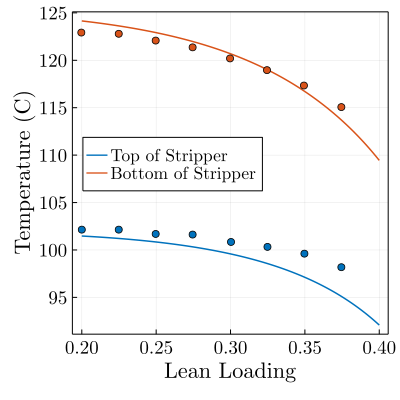

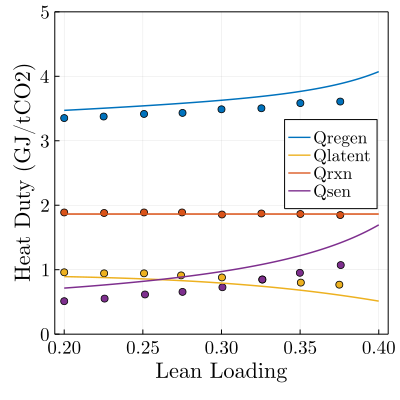

In [4]:
Ttop = zeros(100)
Tlean = zeros(100)
Qregen = zeros(100)
Qlatent = zeros(100)
Qrxn = zeros(100)
Qsen = zeros(100)
i = 0
for αlean in LinRange(0.2, 0.4, 100)
    i += 1
    Tsol = Estimate_Ttop(αlean = αlean, αrich = 0.51, p = 2e5)
    Qsol = Q_regen(αlean = αlean, αrich = 0.51, p = 2e5)
    Ttop[i] = Tsol[1]
    Tlean[i] = Tsol[4]
    Qregen[i] = Qsol[1]
    Qlatent[i] = Qsol[2]
    Qrxn[i] = Qsol[3]
    Qsen[i] = Qsol[4]
    
end

#Kim et al's Data
T_bottom_data = [0.1996774193548387 122.92207792207792
0.22483870967741937 122.79220779220779
0.2496774193548387 122.07792207792208
0.274516129032258 121.36363636363636
0.2996774193548387 120.1948051948052
0.324516129032258 118.96103896103897
0.3493548387096773 117.33766233766234
0.37451612903225795 115.06493506493507]

T_top_data = [0.2 102.14285714285714
0.22483870967741937 102.14285714285714
0.2496774193548387 101.68831168831169
0.274516129032258 101.62337662337663
0.30032258064516126 100.84415584415584
0.32483870967741935 100.32467532467533
0.34967741935483865 99.6103896103896
0.37451612903225795 98.18181818181819
]


plot(LinRange(0.2, 0.4, 100), Ttop .- 273.15, lw = 1.5, label = "Top of Stripper", color = MColor[1])
plot!(LinRange(0.2, 0.4, 100), Tlean .- 273.15, lw = 1.5, label = "Bottom of Stripper", color = MColor[2])
scatter!(T_bottom_data[:,1], T_bottom_data[:,2], color = MColor[2], label = "")
display(scatter!(T_top_data[:,1], T_top_data[:,2], color = MColor[1], label = "",
    xlabel = "Lean Loading", 
    ylabel = "Temperature (C)", 
    size = (400,400), 
    framestyle=:box, 
    legend = :left,
    legendfontsize = 11,
    tickfont = font(12, "serif-roman"), 
    fontfamily = "serif-roman", 
    guidefontsize = 14))


Q_regen_data = [0.2 3.352
0.22507552870090633 3.376
0.25075528700906347 3.4159999999999995
0.275226586102719 3.4319999999999995
0.3 3.4879999999999995
0.3253776435045317 3.5039999999999996
0.3501510574018126 3.5839999999999996
0.3755287009063444 3.6079999999999997
]

Q_rxn_data = [0.2 1.8879999999999995
0.22537764350453174 1.88
0.25075528700906347 1.8879999999999995
0.2749244712990936 1.8879999999999995
0.30030211480362534 1.8559999999999994
0.3253776435045317 1.8719999999999994
0.3501510574018126 1.8639999999999999
0.3755287009063444 1.8479999999999999
]

Q_latent_data = [0.2 0.9599999999999991
0.22537764350453174 0.9439999999999991
0.25075528700906347 0.9439999999999991
0.2743202416918429 0.911999999999999
0.30030211480362534 0.879999999999999
0.3259818731117825 0.8479999999999999
0.35045317220543803 0.7999999999999998
0.3749244712990937 0.7679999999999998
]

Q_sens_data = [0.2 0.5119999999999996
0.2256797583081571 0.5519999999999996
0.25135951661631417 0.6159999999999997
0.275226586102719 0.6559999999999997
0.30060422960725075 0.7279999999999998
0.3259818731117825 0.8479999999999999
0.3498489425981872 0.952
0.3758308157099698 1.0719999999999992
]

scatter(Q_regen_data[:,1], Q_regen_data[:,2], color = MColor[1], label = "")
scatter!(Q_rxn_data[:,1], Q_rxn_data[:,2], color = MColor[2], label = "")
scatter!(Q_latent_data[:,1], Q_latent_data[:,2], color = MColor[3], label = "")
scatter!(Q_sens_data[:,1], Q_sens_data[:,2], color = MColor[4], label = "")
plot!(LinRange(0.2, 0.4, 100), Qregen / 1e9, label = "Qregen", lw = 1.5, color = MColor[1])
plot!(LinRange(0.2, 0.4, 100), Qlatent / 1e9, label = "Qlatent", lw = 1.5, color = MColor[3])
plot!(LinRange(0.2, 0.4, 100), Qrxn / 1e9, label = "Qrxn", lw = 1.5, color = MColor[2])
plot!(LinRange(0.2, 0.4, 100), Qsen / 1e9, label = "Qsen", lw = 1.5, color = MColor[4],
    ylims = (0,5), 
    xlabel = "Lean Loading", 
    ylabel = "Heat Duty (GJ/tCO2)", 
    legend = :right,
    size = (400,400), 
    framestyle=:box, 
    legendfontsize = 11,
    tickfont = font(12, "serif-roman"), 
    fontfamily = "serif-roman", 
    guidefontsize = 14)





These results look great. We will now do some approximate analysis of energy requirements.

## Energy Requirements, Separation of 66% O2/33% CO2 using MEA

In [5]:
#Separate 1 mol of CO2, 2 mol of O2
nCO2 = 2.0; nO2 = 1.0;
ntot = nCO2 + nO2
yCO2 = nCO2/ntot; yO2 = nO2/ntot
Qregen = Q_regen(αlean = 0.25, αrich = 0.45, p = 1.6e5)[1] / 1e6 * 44 * nCO2
Weq_process = Qregen*(393-313)/393

R = 8.314; T = 313.0
Wmin = -R*T*ntot*(yO2*log(yO2) + yCO2*log(yCO2))

η = Wmin / Weq_process

println("The Second Law Efficiency of this process is ", round(100*η, sigdigits = 3), "%")


The Second Law Efficiency of this process is 6.51%


## Creat Plot, with Simple Stripper and 'Advanced Stripper' (Recover Heat of Condensation Losses)

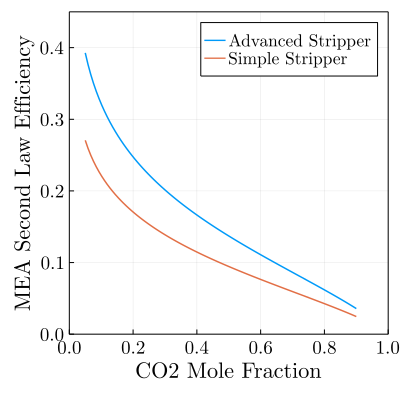

In [6]:
yCO2vals = LinRange(0.05, 0.9, 100)
ηvals = zeros(length(yCO2vals))
ηvals_advanced_stripper = zeros(length(yCO2vals))
i = 0
for yCO2 = yCO2vals
    i += 1
    ntot = 1.0
    nCO2 = yCO2; nO2 = 1-yCO2
    yO2 = 1-yCO2
    Qregen = Q_regen(αlean = 0.25, αrich = 0.45, p = 1.6e5)[1] / 1e6 * 44 * nCO2     #Energy per mole of CO2 separated
    Qregen_advanced_stripper = Qregen - Q_regen(αlean = 0.25, αrich = 0.45, p = 1.6e5)[2] / 1e6 * 44 * nCO2     #Energy per mole of CO2 separated

    Weq_process = Qregen*(393-313)/393
    R = 8.314; T = 313.0
    Wmin = -R*T*ntot*(yO2*log(yO2) + yCO2*log(yCO2))
    ηvals[i] = Wmin / Weq_process
      
    Weq_process_advanced_stripper = Qregen_advanced_stripper*(393-313)/393
    ηvals_advanced_stripper[i] = Wmin / Weq_process_advanced_stripper
end
plot(yCO2vals, ηvals_advanced_stripper, lw = 1.5,label =  "Advanced Stripper")
plot!(yCO2vals, ηvals, label = "Simple Stripper",
    lw = 1.5,
    ylims = (0,0.45), 
    xlabel = "CO2 Mole Fraction", 
    ylabel = "MEA Second Law Efficiency", 
    size = (400,400),
    xlims = (0,1),
    framestyle=:box, 
    legendfontsize = 11,
    tickfont = font(12, "serif-roman"), 
    fontfamily = "serif-roman", 
    guidefontsize = 14)

# Energy Requirements for Capture Using K2CO3 

This is an ideal application for K2CO3:

1. Kinetics for K2CO3 are slow, but with 7x increase in concentration, they become much more reasonable!
2. Low enthalpy of absorption is usually a problem, but when we don't want to pressurize the gas stream, it actually becomes an advantage!

To apply Kim et al's model to K2CO3, we need:

 - VLE data.
 - Estimates of $\Delta h$ (which we can get from VLE).
 - Physical parameters (e.g. cP).
 
For the vapor-liquid equilibria, I think it's simplest to fit a Gabrielson-like expression to a rigorous model; we will use the model of H. Kaur, C.-C. Chen (2020) in Fluid Phase Equilibria, doi.org/10.1016/j.fluid.2019.112339. I ported their Figure 11 into the web plot digitizer, and grabbed a bunch of points. We will assume the following stoichiometry,

$$
CO2 + H2O + K2CO3 -> 2KHCO3
$$

so for a loading defined as (I don't think this is the conventional definition, but it matches with both Kim's approach with amines and also with Kaur and Chen's definition),


$$
\alpha = [CO2]_{chemically stored}/[K2CO3]_{initial}
$$

We may say that

$$
[CO2]_{chemically stored} = 0.5[KHCO3]
$$

as half of the KHCO3 is comes from CO2 (the other half comes from K2CO3). Further, we have

$$
[K2CO3]_{initial} = [K2CO3] + 0.5[KHCO3]
$$

Therefore we have

$$
\alpha = \frac{0.5[KHCO3]}{[K2CO3] + 0.5[KHCO3]} = \frac{[KHCO3]}{2[K2CO3] + [KHCO3]}
$$

The equilibrium constant is

$$
Keq' = \frac{[KHCO3]^2}{[CO2][K2CO3]}
$$

Following Gabrielson's approach, we may lump this in with a Henry's constant to give

$$
p_{CO2} = \frac{1}{Keq}\frac{[KHCO3]^2}{[K2CO3]}
$$

Now, note that

$$
2[K2CO3] + [KHCO3] = [K+]
$$

which is constant, so that

$$
[KHCO3] = \alpha[K+]
$$

and

$$
[K2CO3] = ([K+] - [KHCO3])/2 = ([K+] - \alpha[K+])/2 = [K+](0.5 - 0.5\alpha)
$$

So overall we get

$$
p_{CO2} = \frac{1}{Keq}\frac{2[K+] \alpha^2}{1-\alpha}
$$

Finally, $2[K+] = 4[K2CO3]_{initial}$, so we get

$$
p_{CO2} = \frac{4[K2CO3]_{initial}}{Keq}\frac{\alpha^2}{1-\alpha}
$$

In order to remain consistent with Gabrielson, we use mole fraction, drop the factor of 4, and bringing Keq to the top, we may write

$$
p_{CO2} = x_{K2CO3,initial}Keq\frac{\alpha^2}{1-\alpha}
$$

as mole fraction and constant are approximately proportional.

For $K_{eq}$ we will again follow Gabrielson and assume,

$$
\log K_{eq} = A + \frac{B}{T} + Cx_{K2CO3,initial}\alpha  + D\sqrt{x_{K2CO3,initial}\alpha}
$$

We now fit this expression to their the model of Kaur and Chen based on a 30wt% (3.1M) K2CO3 solution:

In [7]:
pCO2_323K_data = [0.06749379652605458 0.0451113386070984
0.0913151364764268 0.08483428982440726
0.11662531017369732 0.14171916062548542
0.15086848635235733 0.2665104764654968
0.1910669975186105 0.44521668184840363
0.23126550868486356 0.7149665346119836
0.278908188585608 1.125715306862486
0.3265508684863525 1.6378937069540647
0.37419354838709684 2.430604433384409
0.4218362282878413 3.399605877642248
0.4650124069478909 4.570881896148752
0.5111662531017371 6.268200173970413
0.5692307692307693 9.120108393559105
0.6302729528535981 13.010252169108316
0.6838709677419356 18.559720367285216
0.7344913151364766 26.47629082314937
0.7895781637717124 38.52248420036753
0.8267990074441689 51.794746792312125
0.8595533498759307 68.27877398078833
0.8878411910669977 90.00895390054401
0.9146401985111665 125.89254117941675
0.9399503722084368 165.95869074375614
0.9622828784119108 266.51047646549654
0.9846153846153847 403.37992948044575
]

pCO2_343K_data = [0.06302729528535983 0.1096478196143185
0.09875930521091814 0.23674767042858813
0.1449131513647643 0.5423575800529784
0.2208436724565757 1.3713327791846401
0.18064516129032265 0.8539423876529779
0.2655086848635237 2.11696796306365
0.3220843672456577 3.2680275894101287
0.35781637717121595 4.570881896148752
0.4009925558312656 6.0255958607435804
0.4382133995037222 7.788047137249819
0.476923076923077 9.48730488076272
0.5290322580645163 13.803842646028851
0.5781637717121589 17.84138526495628
0.6258064516129034 23.988329190194897
0.6779156327543426 33.55168113317846
0.7240694789081887 45.11133860709836
0.7612903225806453 59.46832610410716
0.8014888337468984 75.36034138227309
0.8372208436724566 103.3441063880556
0.8714640198511168 141.71916062548527
0.8997518610421837 186.82223847710367
0.9295285359801491 271.82269518353365
0.9548387096774196 395.49669364386557
]

pCO2_363K_data = [0.03771712158808935 0.08483428982440726
0.05111662531017372 0.15641763468322997
0.07047146401985116 0.29415174464092225
0.09875930521091814 0.5317583102360061
0.1285359801488834 0.9060305822453381
0.16575682382134 1.5135612484362104
0.2074441687344914 2.3831032401582486
0.24317617866004965 3.5364818096244375
0.28635235732009934 5.248074602497728
0.33250620347394544 7.486618692932303
0.39057071960297773 10.680004325145767
0.442679900744417 15.539196960155824
0.4977667493796527 20.48465110448066
0.549875930521092 29.22229264881484
0.6019851116625312 40.87225238405592
0.6585607940446653 57.166665019136154
0.7062034739454095 76.86246100397739
0.7523573200992557 105.40401226355512
0.8014888337468984 150.36364920323922
0.8491315136476429 218.77616239495518
0.8878411910669977 312.0942118800175
0.9250620347394543 481.7892914369251
]

pCO2_383K_data = [0.022828784119106688 0.08483428982440726
0.04218362282878413 0.19054607179632482
0.06153846153846154 0.41142029787528467
0.0928039702233251 0.9060305822453381
0.14342431761786606 1.9562689932014867
0.18808933002481393 3.7521977119329635
0.22828784119106704 5.6791810532527425
0.2699751861042184 8.263097117956942
0.3176178660049629 11.787686347935878
0.36972704714640214 17.150852592245137
0.4173697270471465 23.988329190194897
0.46203473945409446 30.398849192403606
0.5171215880893302 44.22972974370843
0.5707196029776677 59.46832610410716
0.6243176178660051 81.55086490980369
0.6764267990074443 116.3360424350593
0.7151364764267991 150.36364920323922
0.7553349875930523 202.16887095706863
0.7985111662531018 282.76690050505215
0.8416873449131517 380.1893963205613
0.878908188585608 553.1681197617227
0.9161290322580646 773.6979186892017
0.9414392059553351 1019.9324949191065
]

pCO2_393K_data = [0.016873449131513646 0.07102783406586612
0.027295285359801497 0.1445439770745931
0.04069478908188587 0.28276690050505243
0.05707196029776679 0.4913925540405725
0.07940446650124072 0.8709635899560815
0.10471464019851118 1.4549803995462103
0.13895781637717125 2.479052443903204
0.16873449131513651 3.826988373761554
0.21042183622828792 5.907837911587944
0.24466501240694793 8.427801259276702
0.278908188585608 11.557320123299707
0.32506203473945416 16.48704628438744
0.3727047146401986 23.51952635070959
0.4263027295285361 32.89598213638597
0.4709677419354841 44.22972974370843
0.5200992555831266 59.46832610410716
0.5632754342431764 79.95712002123398
0.6228287841191068 109.64781961431851
0.6764267990074443 159.53542839181193
0.719602977667494 210.3086535159893
0.7746898263027298 305.9949687207196
0.820843672456576 454.0909610972475
0.8506203473945413 564.1941404982849
0.886352357320099 773.6979186892017
0.9205955334987597 1082.1456407174235
]

pCO2_403K_data = [0.013895781637717125 0.10750497720245208
0.025806451612903236 0.21877616239495562
0.05260545905707198 0.5986084693840026
0.08982630272952857 1.4549803995462103
0.11811414392059555 2.528466144145503
0.1478908188585608 3.826988373761554
0.18213399503722089 6.0255958607435804
0.22531017369727052 9.48730488076272
0.27295285359801497 14.078987669434968
0.3265508684863525 21.30941015366798
0.3771712158808934 31.622776601683825
0.4218362282878413 43.36535012272196
0.47394540942928054 60.65367821202511
0.527543424317618 83.17637711026708
0.5751861042183624 109.64781961431851
0.6228287841191068 150.36364920323922
0.674937965260546 210.3086535159893
0.7181141439205957 282.76690050505215
0.759801488833747 372.7593720314938
0.8089330024813897 542.3575800529773
0.8446650124069481 729.2176014304688
0.8878411910669977 1060.9973170854325
0.9325062034739455 1513.5612484362073
];

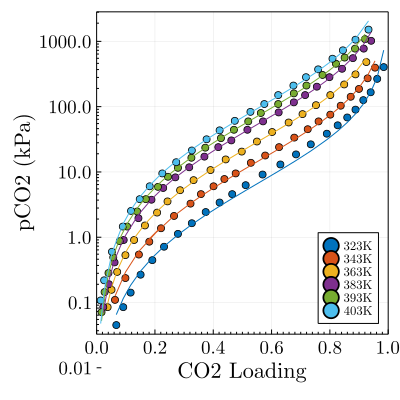

The Predicted Enthalpy of Absorption is: -35846.09164014698J/mol


In [8]:
#Fit to data.

function pCO2_K2CO3_model(T, α, x_K2CO30; A = 26.30030348688424, B = -4311.533, C = 34.581690126627, D = -10.7831815)
    Keq = exp(A + B/T + C*x_K2CO30*α + D*sqrt(x_K2CO30*α))
    pCO2 = x_K2CO30*Keq * α^2/(1-α)
end

function resid(y)
    A, B, C, D = y
    
    x_K2CO30 = 0.053    #30 wt% K2CO3
    
    SSE = 0.0
    for i = 1:size(pCO2_323K_data)[1]
        SSE += (log(pCO2_K2CO3_model(323.15, pCO2_323K_data[i,1], x_K2CO30, A = A, B = B, C = C, D = D)) - log(1e3*pCO2_323K_data[i,2]))^2
    end
    for i = 1:size(pCO2_343K_data)[1]
        SSE += (log(pCO2_K2CO3_model(343.15, pCO2_343K_data[i,1], x_K2CO30, A = A, B = B, C = C, D = D)) - log(1e3*pCO2_343K_data[i,2]))^2
    end
    for i = 1:size(pCO2_363K_data)[1]
        SSE += (log(pCO2_K2CO3_model(363.15, pCO2_363K_data[i,1], x_K2CO30, A = A, B = B, C = C, D = D)) - log(1e3*pCO2_363K_data[i,2]))^2
    end
    for i = 1:size(pCO2_383K_data)[1]
        SSE += (log(pCO2_K2CO3_model(383.15, pCO2_383K_data[i,1], x_K2CO30, A = A, B = B, C = C, D = D)) - log(1e3*pCO2_383K_data[i,2]))^2
    end
    for i = 1:size(pCO2_393K_data)[1]
        SSE += (log(pCO2_K2CO3_model(393.15, pCO2_393K_data[i,1], x_K2CO30, A = A, B = B, C = C, D = D)) - log(1e3*pCO2_393K_data[i,2]))^2
    end
    for i = 1:size(pCO2_403K_data)[1]
        SSE += (log(pCO2_K2CO3_model(403.15, pCO2_403K_data[i,1], x_K2CO30, A = A, B = B, C = C, D = D)) - log(1e3*pCO2_403K_data[i,2]))^2
    end
    
    return SSE
end
    

y0 = [30.96, -3584, 0.0, 0.0]
sol = optimize(resid, y0)

#Create Plot
A, B, C, D = sol.minimizer

scatter(pCO2_323K_data[:,1], pCO2_323K_data[:,2], label = "323K", color = MColor[1])
scatter!(pCO2_343K_data[:,1], pCO2_343K_data[:,2], label = "343K", color = MColor[2])
scatter!(pCO2_363K_data[:,1], pCO2_363K_data[:,2], label = "363K", color = MColor[3])
scatter!(pCO2_383K_data[:,1], pCO2_383K_data[:,2], label = "383K", color = MColor[4])
scatter!(pCO2_393K_data[:,1], pCO2_393K_data[:,2], label = "393K", color = MColor[5])
scatter!(pCO2_403K_data[:,1], pCO2_403K_data[:,2], label = "403K", color = MColor[6],
    lw = 1.5,
    yscale = :log10,
    xlabel = "CO2 Loading", 
    ylabel = "pCO2 (kPa)", 
    legend = :bottomright,
    size = (400,400),
    xlims = (0,1),
    yticks=([0.01, 0.1, 1, 10, 100, 1000], [0.01, 0.1, 1, 10, 100, 1000]), 
    minorticks=10,
    framestyle=:box, 
    legendfontsize = 11,
    tickfont = font(12, "serif-roman"), 
    fontfamily = "serif-roman", 
    guidefontsize = 14)

plot!(pCO2_323K_data[:,1], α -> pCO2_K2CO3_model(323.15, α, 0.053; A = A, B = B, C = C, D = D)/1e3, color = MColor[1], label = "")
plot!(pCO2_343K_data[:,1], α -> pCO2_K2CO3_model(343.15, α, 0.053; A = A, B = B, C = C, D = D)/1e3, color = MColor[2], label = "")
plot!(pCO2_363K_data[:,1], α -> pCO2_K2CO3_model(363.15, α, 0.053; A = A, B = B, C = C, D = D)/1e3, color = MColor[3], label = "")
plot!(pCO2_383K_data[:,1], α -> pCO2_K2CO3_model(383.15, α, 0.053; A = A, B = B, C = C, D = D)/1e3, color = MColor[4], label = "")
plot!(pCO2_393K_data[:,1], α -> pCO2_K2CO3_model(393.15, α, 0.053; A = A, B = B, C = C, D = D)/1e3, color = MColor[5], label = "")
display(plot!(pCO2_403K_data[:,1], α -> pCO2_K2CO3_model(403.15, α, 0.053; A = A, B = B, C = C, D = D)/1e3, color = MColor[6], label = ""))

println("The Predicted Enthalpy of Absorption is: ", B*8.314, "J/mol")

We are now in a position to estimate energy requirements for a K2CO3-based stripper. We change the following parameters:

 - cp_K2CO3 = 120 J/mol.K
 - $\Delta h = -35800 J/mol$.
 - $\alpha_{rich} \approx 0.65$. 
 - $\alpha_{lean} \approx 0.35$
 - $p = 1.2e5$
 - $r_w = 0.947 / 0.053 = 17.9$. This will slightly shift with loading, as water is consumed. However, total water consumption is minor.
 - We use pCO2 function for K2CO3 derived above.
 - The maximum allowable loading is 1.0.

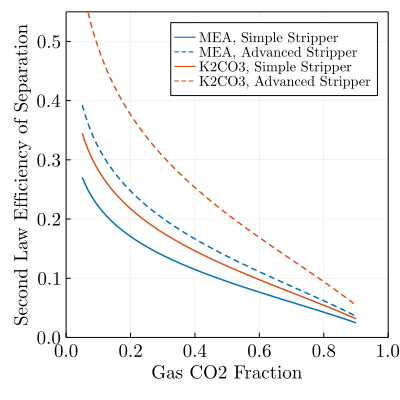

In [9]:
yCO2vals = LinRange(0.05, 0.9, 100)
ηvals = zeros(length(yCO2vals))
ηvals_advanced_stripper = zeros(length(yCO2vals))
ηvals_K2CO3 = zeros(length(yCO2vals))
ηvals_K2CO3_advanced_stripper = zeros(length(yCO2vals))

i = 0
for yCO2 = yCO2vals
    i += 1
    ntot = 1.0
    nCO2 = yCO2; nO2 = 1-yCO2
    yO2 = 1-yCO2
    Qregen = Q_regen(αlean = 0.25, αrich = 0.45, p = 1.6e5)[1] / 1e6 * 44 * nCO2     #Energy per mole of CO2 separated
    Qregen_advanced_stripper = Qregen - Q_regen(αlean = 0.25, αrich = 0.45, p = 1.6e5)[2] / 1e6 * 44 * nCO2     #Energy per mole of CO2 separated
    
    Qregen_K2CO3 = Q_regen(M = 2.2727e4, cam = 120.0, cw = 75, cCO2 = 37.0, Δh = -35800, λ = 40000, ΔT_MTA = 10.0,
    T1 = 318.15, T4 = 313.15, αrich = 0.65, αlean = 0.3, rw = 17.9, p = 1e5, 
    pCO2 = pCO2_K2CO3_model, pwater = pvap_water_Stull, maxloading = 1.0)[1] / 1e6 * 44 * nCO2     #Energy per mole of CO2 separated
    
    Qregen_K2CO3_advanced_stripper = Qregen_K2CO3 - Q_regen(M = 2.2727e4, cam = 120.0, cw = 75, cCO2 = 37.0, Δh = -35800, λ = 40000, ΔT_MTA = 10.0,
    T1 = 318.15, T4 = 313.15, αrich = 0.65, αlean = 0.3, rw = 17.9, p = 1e5, 
    pCO2 = pCO2_K2CO3_model, pwater = pvap_water_Stull, maxloading = 1.0)[2] / 1e6 * 44 * nCO2     #Energy per mole of CO2 separated
    
    
    Weq_process = Qregen*(393-313)/393
    R = 8.314; T = 313.0
    Wmin = -R*T*ntot*(yO2*log(yO2) + yCO2*log(yCO2))
    ηvals[i] = Wmin / Weq_process
      
    Weq_process_advanced_stripper = Qregen_advanced_stripper*(393-313)/393
    ηvals_advanced_stripper[i] = Wmin / Weq_process_advanced_stripper
    
    Weq_process_K2CO3 = Qregen_K2CO3*(393-313)/393
    ηvals_K2CO3[i] = Wmin / Weq_process_K2CO3
        
    Weq_process_K2CO3_advanced_stripper = Qregen_K2CO3_advanced_stripper*(393-313)/393
    ηvals_K2CO3_advanced_stripper[i] = Wmin / Weq_process_K2CO3_advanced_stripper
    
end
plot(yCO2vals, ηvals, label = "MEA, Simple Stripper", lw = 1.5, color = MColor[1])
plot!(yCO2vals, ηvals_advanced_stripper, lw = 1.5, label =  "MEA, Advanced Stripper", color = MColor[1], ls = :dash)
plot!(yCO2vals, ηvals_K2CO3, lw = 1.5,label =  "K2CO3, Simple Stripper", color = MColor[2])
plot!(yCO2vals, ηvals_K2CO3_advanced_stripper, lw = 1.5,label =  "K2CO3, Advanced Stripper", color = MColor[2], ls = :dash,
    ylims = (0,0.55), 
    xlabel = "Gas CO2 Fraction", 
    ylabel = "Second Law Efficiency of Separation", 
    size = (400,400),
    xlims = (0,1),
    framestyle=:box, 
    legendfontsize = 9,
    tickfont = font(12, "serif-roman"), 
    fontfamily = "serif-roman", 
    guidefontsize = 12)

# Varying Rich Loading with Gas Fraction.

Above, we assumed a fixed rich loading. But it is more reasonable to assume a CO2-concentration dependent rich loading. We now assume assume that the rich loading is 25% of the inlet gas partial pressure.

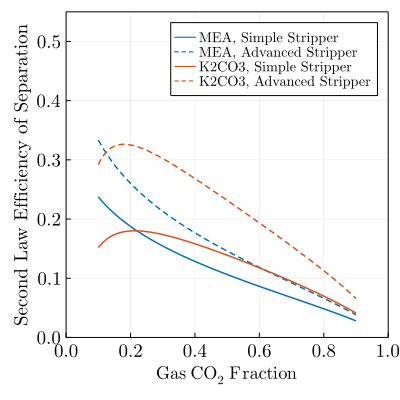

In [10]:
yCO2vals = LinRange(0.1, 0.9, 100)
ηvals = zeros(length(yCO2vals))
ηvals_advanced_stripper = zeros(length(yCO2vals))
ηvals_K2CO3 = zeros(length(yCO2vals))
ηvals_K2CO3_advanced_stripper = zeros(length(yCO2vals))

i = 0
for yCO2 = yCO2vals
    i += 1
    ntot = 1.0
    nCO2 = yCO2; nO2 = 1-yCO2
    yO2 = 1-yCO2
    
    pCO2absorber = 1e5 * yCO2
    
    #Calculate αrich for MEA
    
    resid(α) = pCO2_MEA_Gabrielson(313.15, α, 0.11) - pCO2absorber * 0.25
    αrichMEA = find_zero(resid, [0.00001, 0.499999])

    #Calculate αrich for K2CO3
    
    temp(α) = pCO2_K2CO3_model(313.15, α, 0.053) - pCO2absorber * 0.25
    
    αrichK2CO3 = find_zero(temp, [0.25, 1.0])
    
    
    Qregen = Q_regen(αlean = 0.25, αrich = αrichMEA, p = 1.6e5)[1] / 1e6 * 44 * nCO2     #Energy per mole of CO2 separated
    Qregen_advanced_stripper = Qregen - Q_regen(αlean = 0.25, αrich = αrichMEA, p = 1.6e5)[2] / 1e6 * 44 * nCO2     #Energy per mole of CO2 separated
    
    Qregen_K2CO3 = Q_regen(M = 2.2727e4, cam = 120.0, cw = 75, cCO2 = 37.0, Δh = -35800, λ = 40000, ΔT_MTA = 10.0,
    T1 = 318.15, T4 = 313.15, αrich = αrichK2CO3, αlean = 0.3, rw = 17.9, p = 1e5, 
    pCO2 = pCO2_K2CO3_model, pwater = pvap_water_Stull, maxloading = 1.0)[1] / 1e6 * 44 * nCO2     #Energy per mole of CO2 separated
    
    Qregen_K2CO3_advanced_stripper = Qregen_K2CO3 - Q_regen(M = 2.2727e4, cam = 120.0, cw = 75, cCO2 = 37.0, Δh = -35800, λ = 40000, ΔT_MTA = 10.0,
    T1 = 318.15, T4 = 313.15, αrich = αrichK2CO3, αlean = 0.3, rw = 17.9, p = 1e5, 
    pCO2 = pCO2_K2CO3_model, pwater = pvap_water_Stull, maxloading = 1.0)[2] / 1e6 * 44 * nCO2     #Energy per mole of CO2 separated
    
    
    Weq_process = Qregen*(393-313)/393
    R = 8.314; T = 313.0
    Wmin = -R*T*ntot*(yO2*log(yO2) + yCO2*log(yCO2))
    ηvals[i] = Wmin / Weq_process
      
    Weq_process_advanced_stripper = Qregen_advanced_stripper*(393-313)/393
    ηvals_advanced_stripper[i] = Wmin / Weq_process_advanced_stripper
    
    Weq_process_K2CO3 = Qregen_K2CO3*(393-313)/393
    ηvals_K2CO3[i] = Wmin / Weq_process_K2CO3
        
    Weq_process_K2CO3_advanced_stripper = Qregen_K2CO3_advanced_stripper*(393-313)/393
    ηvals_K2CO3_advanced_stripper[i] = Wmin / Weq_process_K2CO3_advanced_stripper
    
end
plot(yCO2vals, ηvals, label = "MEA, Simple Stripper", lw = 1.5, color = MColor[1])
plot!(yCO2vals, ηvals_advanced_stripper, lw = 1.5, label =  "MEA, Advanced Stripper", color = MColor[1], ls = :dash)
plot!(yCO2vals, ηvals_K2CO3, lw = 1.5,label =  "K2CO3, Simple Stripper", color = MColor[2])
display(plot!(yCO2vals, ηvals_K2CO3_advanced_stripper, lw = 1.5,label =  "K2CO3, Advanced Stripper", color = MColor[2], ls = :dash,
    ylims = (0,0.55), 
    xlabel = L"$\mathrm{Gas\ CO_2\ Fraction}$", 
    ylabel = "Second Law Efficiency of Separation", 
    size = (400,400),
    xlims = (0,1),
    framestyle=:box, 
    legendfontsize = 9,
    tickfont = font(12, "serif-roman"), 
    fontfamily = "serif-roman", 
    dpi = 300,
    guidefontsize = 12))
savefig("Figure5.png")

## Pre-Compression for K2CO3

Because of the slow kinetics of CO2 absorption into K2CO3, it is possible that we will need to pre-compress the CO2/O2 mixture before running it through the K2CO3 absorber. We now see how this affects the second law efficiency.

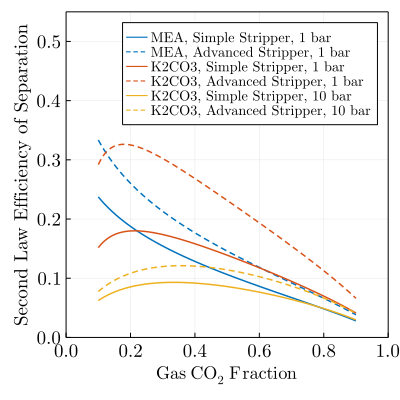

In [11]:
yCO2vals = LinRange(0.1, 0.9, 100)
ηvals = zeros(length(yCO2vals))
ηvals_advanced_stripper = zeros(length(yCO2vals))
ηvals_K2CO3 = zeros(length(yCO2vals))
ηvals_K2CO3_advanced_stripper = zeros(length(yCO2vals))
ηvals_K2CO3_10_bar = zeros(length(yCO2vals))
ηvals_K2CO3_advanced_stripper_10_bar = zeros(length(yCO2vals))
i = 0
for yCO2 = yCO2vals
    i += 1
    ntot = 1.0
    nCO2 = yCO2; nO2 = 1-yCO2
    yO2 = 1-yCO2
    
    pCO2absorber = 1e5 * yCO2
    
    #Calculate αrich for MEA
    
    resid(α) = pCO2_MEA_Gabrielson(313.15, α, 0.11) - pCO2absorber * 0.25
    αrichMEA = find_zero(resid, [0.00001, 0.499999])

    #Calculate αrich for K2CO3
    
    temp(α) = pCO2_K2CO3_model(313.15, α, 0.053) - pCO2absorber * 0.25
    
    αrichK2CO3 = find_zero(temp, [0.25, 1.0])
    
    
    Qregen = Q_regen(αlean = 0.25, αrich = αrichMEA, p = 1.6e5)[1] / 1e6 * 44 * nCO2     #Energy per mole of CO2 separated
    Qregen_advanced_stripper = Qregen - Q_regen(αlean = 0.25, αrich = αrichMEA, p = 1.6e5)[2] / 1e6 * 44 * nCO2     #Energy per mole of CO2 separated
    
    Qregen_K2CO3 = Q_regen(M = 2.2727e4, cam = 120.0, cw = 75, cCO2 = 37.0, Δh = -35800, λ = 40000, ΔT_MTA = 10.0,
    T1 = 318.15, T4 = 313.15, αrich = αrichK2CO3, αlean = 0.3, rw = 17.9, p = 1e5, 
    pCO2 = pCO2_K2CO3_model, pwater = pvap_water_Stull, maxloading = 1.0)[1] / 1e6 * 44 * nCO2     #Energy per mole of CO2 separated
    
    Qregen_K2CO3_advanced_stripper = Qregen_K2CO3 - Q_regen(M = 2.2727e4, cam = 120.0, cw = 75, cCO2 = 37.0, Δh = -35800, λ = 40000, ΔT_MTA = 10.0,
    T1 = 318.15, T4 = 313.15, αrich = αrichK2CO3, αlean = 0.3, rw = 17.9, p = 1e5, 
    pCO2 = pCO2_K2CO3_model, pwater = pvap_water_Stull, maxloading = 1.0)[2] / 1e6 * 44 * nCO2     #Energy per mole of CO2 separated
    
    
    Weq_process = Qregen*(393-313)/393
    R = 8.314; T = 313.0
    Wmin = -R*T*ntot*(yO2*log(yO2) + yCO2*log(yCO2))
    ηvals[i] = Wmin / Weq_process
      
    Weq_process_advanced_stripper = Qregen_advanced_stripper*(393-313)/393
    ηvals_advanced_stripper[i] = Wmin / Weq_process_advanced_stripper
    
    Weq_process_K2CO3 = Qregen_K2CO3*(393-313)/393                      #Work per mol CO2 separated
    ηvals_K2CO3[i] = Wmin / Weq_process_K2CO3

    #Account for Precompression
    n_in_absorber_total = 1/yCO2                                        #Total gas flow rate per mol CO2
    pabsorber = 10.0                                                    #Absorber pressure, bar
    W_compression_10_bar = 3.48*log(pabsorber)*1e3                      #Compression work per mol CO2
    Weq_process_K2CO3_10_bar = Weq_process_K2CO3 + W_compression_10_bar
    ηvals_K2CO3_10_bar[i] = Wmin / Weq_process_K2CO3_10_bar

    #Advanced Stripper
    Weq_process_K2CO3_advanced_stripper = Qregen_K2CO3_advanced_stripper*(393-313)/393
    ηvals_K2CO3_advanced_stripper[i] = Wmin / Weq_process_K2CO3_advanced_stripper

    #Account for Precompression
    n_in_absorber_total = 1/yCO2                                        #Total gas flow rate per mol CO2
    pabsorber = 10.0                                                    #Absorber pressure, bar
    W_compression_10_bar = 3.48*log(pabsorber)*1e3                      #Compression work per mol CO2
    W_eq_process_K2CO2_advanced_stripper_10_bar = Weq_process_K2CO3_advanced_stripper + W_compression_10_bar
    ηvals_K2CO3_advanced_stripper_10_bar[i] = Wmin / W_eq_process_K2CO2_advanced_stripper_10_bar
    
end
plot(yCO2vals, ηvals, label = "MEA, Simple Stripper, 1 bar", lw = 1.5, color = MColor[1])
plot!(yCO2vals, ηvals_advanced_stripper, lw = 1.5, label =  "MEA, Advanced Stripper, 1 bar", color = MColor[1], ls = :dash)
plot!(yCO2vals, ηvals_K2CO3, lw = 1.5,label =  "K2CO3, Simple Stripper, 1 bar", color = MColor[2])
plot!(yCO2vals, ηvals_K2CO3_advanced_stripper, lw = 1.5,label =  "K2CO3, Advanced Stripper, 1 bar", color = MColor[2], ls = :dash)
plot!(yCO2vals, ηvals_K2CO3_10_bar, lw = 1.5,label =  "K2CO3, Simple Stripper, 10 bar", color = MColor[3])
display(plot!(yCO2vals, ηvals_K2CO3_advanced_stripper_10_bar, lw = 1.5,label =  "K2CO3, Advanced Stripper, 10 bar", color = MColor[3], ls = :dash,
    ylims = (0,0.55), 
    xlabel = L"$\mathrm{Gas\ CO_2\ Fraction}$", 
    ylabel = "Second Law Efficiency of Separation", 
    size = (400,400),
    xlims = (0,1),
    framestyle=:box, 
    legendfontsize = 9,
    tickfont = font(12, "serif-roman"), 
    fontfamily = "serif-roman", 
    dpi = 300,
    guidefontsize = 12))
#savefig("Figure5.png")